In [1]:
import matplotlib.pyplot as plt
import jax.numpy as np
import jax
from jax import jit, value_and_grad, grad
import numpy as onp
import torch
import torch.nn as nn

In [22]:
@jit
def compute_potential_point(coord, target_coord):
    return 20 * np.sum((coord - target_coord) ** 2)

@jit
def compute_rolling_friction_force(velocity, mass, radius, f, g=9.8):
    return - np.sign(velocity) * mass * g * radius * f / radius

@jit
def compute_acceleration(potential_force, friction_force, mass):
    return (potential_force + friction_force) / mass

@jit
def get_new_cv(current_coordinate, current_velocity, acceleration, dt):
    new_velocity = current_velocity + acceleration * dt
    new_coordinate = current_coordinate + new_velocity * dt
    return new_coordinate, new_velocity

@jit
def run_sim(coordinate_init, velocity_init, target_coordinate, constants):
    trajectory = []
    sim_time = 0.2
    n_steps = 20
    dt = sim_time / n_steps
    coordinate = coordinate_init
    velocity = velocity_init
    for t in np.linspace(0, sim_time, n_steps):
        trajectory.append(coordinate)
        l2_force = - grad(compute_potential_point)(coordinate, target_coordinate)
        friction_force = compute_rolling_friction_force(velocity,
                                                        constants['mass'],
                                                        constants['radius'],
                                                        constants['f'])
        acceleration = compute_acceleration(l2_force,
                                            friction_force,
                                            constants['mass'])
        coordinate, velocity = get_new_cv(coordinate, velocity, acceleration, dt)
    return coordinate, trajectory

@jit
def compute_loss(coordinate_init, velocity_init, target_coordinate, attractor, constants):
    final_coord, _ = run_sim(coordinate_init, velocity_init, attractor, constants)
    return np.sum(np.abs(final_coord - target_coordinate))


In [23]:
from collections import namedtuple


In [24]:
constants = {}
constants['radius'] = 0.05
constants['ro'] = 1000.
constants['volume'] = 4 * np.pi * (constants['radius'] ** 3) / 3
constants['mass'] = constants['volume'] * constants['ro']
constants['f'] = 0.007
const = namedtuple('Constants', list(constants.keys()))
target_coordinate = np.array([[0.5, 0.5], [0.5, 0.5], [0.5, 0.5]])
coordinate_init = np.array([[0.2, 0.4], [0.2, 0.4], [0.2, 0.4]])
velocity_init = np.array([[1., 0.], [1., 0.1], [1., 0.]])
attractor = np.array([[0., 0.], [0., 0.], [0., 0.]])

#%time trajectory = run_sim(coordinate_init, velocity_init, coordinate_target, sim_time, n_steps)

In [25]:
test = jax.vmap(run_sim, in_axes=(0, 0, 0, None))(coordinate_init, velocity_init, target_coordinate, constants)

In [28]:
target_coordinate = np.array([[0.9, 0.5], [0.9, 0.5], [0.9, 0.5]])
coordinate_init = np.array([[0.2, 0.4], [0.2, 0.4], [0.5, 0.4]])
velocity_init = np.array([[1., 0.1], [1., 0.], [0., 0.]])
attractor = np.array([[0., 0.], [0., 0.], [0., 0.]])

# from functools import partial
# vmap(partial(compute_loss, config=dictionary))(X[i:i+batch], y[i:i+batch])

vmapped_loss = jax.vmap(compute_loss, [0, 0, 0, 0, None])
v_g_loss = value_and_grad(lambda c,v,t,a,con: np.sum(vmapped_loss(c,v,t,a,con)), 1)

In [30]:
v_g_loss(coordinate_init, velocity_init, target_coordinate, attractor, constants)

(DeviceArray(4.421179, dtype=float32),
 DeviceArray([[-0.11271466, -0.11271466],
              [-0.11271466, -0.11271466],
              [-0.11271466, -0.11271466]], dtype=float32))

In [99]:
*[list(constants.values())] * 3

SyntaxError: can't use starred expression here (<ipython-input-99-e976961a1740>, line 1)

In [69]:
onp.random.uniform((-1, 0), (0, 2), (3, 2))

array([[-0.14266101,  0.03199589],
       [-0.72773576,  0.42060547],
       [-0.53287533,  0.04518166]])

In [39]:
onp.array([const] * 3)

array([[5.00000000e-02, 1.00000000e+03, 5.23598776e-04, 5.23598776e-01,
        7.00000000e-03],
       [5.00000000e-02, 1.00000000e+03, 5.23598776e-04, 5.23598776e-01,
        7.00000000e-03],
       [5.00000000e-02, 1.00000000e+03, 5.23598776e-04, 5.23598776e-01,
        7.00000000e-03]])

In [153]:
class Controller(nn.Module):
    def __init__(self):
        super().__init__()
        self.controller = nn.Sequential(nn.Linear(5, 20),
                                        nn.ReLU(),
                                        nn.Linear(20, 50),
                                        nn.ReLU(),
                                        nn.Linear(50, 2))
    
    def forward(self, x):
        return self.controller(x)

In [154]:
ctrl = Controller()
opt = torch.optim.Adam(ctrl.parameters())

In [182]:
from time import time
velocity_init = np.array([1., 0.])
for step in range(1000):
    s = time()
    
    coordinate_init = np.array(onp.random.uniform(-1., 1., size=(3, 2)))
    dist = onp.linalg.norm(coordinate_init - target_coordinate, axis=1).reshape(-1, 1)
    direction = (coordinate_init - target_coordinate) / dist

    net_inp = torch.cat([torch.from_numpy(onp.array(o)) for o in [direction, coordinate_init, dist]], dim=1)
    
    
    controller_out = ctrl(net_inp)
    velocity_init = np.array(controller_out.cpu().data.numpy())
    loss_val, v_grad = v_g_loss(coordinate_init, velocity_init, target_coordinate, attractor)
    opt.zero_grad()
    controller_out.backward(torch.from_numpy(onp.array(v_grad)))
    opt.step()
    if step % 50 == 0:
        print(time() - s, loss_val, velocity_init, v_grad)


0.6643249988555908 0.12732074 [[9.413276  4.3436365]
 [8.1530695 2.9440255]
 [8.42685   4.041438 ]] [[-0.11271466 -0.11271466]
 [ 0.11271466 -0.11271466]
 [ 0.11271466  0.11271466]]
0.015748262405395508 0.08209154 [[8.271927  5.327832 ]
 [9.389867  4.8192487]
 [6.545953  4.8371186]] [[-0.11271466 -0.11271466]
 [-0.11271466 -0.11271466]
 [-0.11271466  0.11271466]]
0.015436649322509766 0.03752011 [[9.665913  3.243392 ]
 [6.4418306 4.9877057]
 [8.852613  3.6939716]] [[-0.11271466 -0.11271466]
 [-0.11271466  0.11271466]
 [-0.11271466 -0.11271466]]
0.022728443145751953 0.074985236 [[7.313988  5.1897907]
 [6.0678377 3.9271722]
 [7.488154  3.5819144]] [[-0.11271466 -0.11271466]
 [-0.11271466 -0.11271466]
 [-0.11271466 -0.11271466]]
0.018134355545043945 0.06592026 [[7.9082417 4.2160354]
 [7.1934    3.1755588]
 [7.956205  5.136003 ]] [[-0.11271466 -0.11271466]
 [-0.11271466 -0.11271466]
 [-0.11271466 -0.11271466]]
0.019081592559814453 0.03827107 [[7.155128  3.0498068]
 [6.5401473 5.010614 ]
 [9

In [156]:
torch.from_numpy(onp.array(v_grad))

tensor([[ 0.1127, -0.1127],
        [ 0.1127, -0.1127],
        [ 0.1127,  0.1127]])

In [195]:
target_coordinate = np.array([[0.9, 0.5]])
coordinate_init = np.array([[-1.2, -0.4]])
attractor = np.array([[0., 0.]])

dist = onp.linalg.norm(coordinate_init - target_coordinate, axis=1).reshape(-1, 1)
direction = (coordinate_init - target_coordinate) / dist
net_inp = torch.cat([torch.from_numpy(onp.array(o)) for o in [direction, coordinate_init, dist]], dim=1)

controller_out = ctrl(net_inp)
velocity_init = np.array(controller_out.cpu().data.numpy())


In [196]:
final_coordinate, trajectory = run_sim(coordinate_init, velocity_init, attractor, constants)

In [197]:
traj = onp.array(trajectory)[:, 0, :]

<ipython-input-198-569d085adff1>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


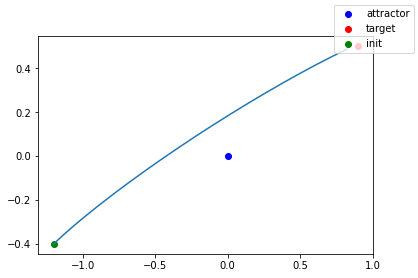

In [198]:
fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
# (or if you have an existing figure)
# fig = plt.gcf()
# ax = fig.gca()

ax.plot(traj[:, 0], traj[:, 1])
ax.scatter(attractor[0, 0], attractor[0, 1], c='b', label='attractor')
ax.scatter(target_coordinate[0, 0], target_coordinate[0, 1], c='r', label='target')
ax.scatter(coordinate_init[0, 0], coordinate_init[0, 1], c='g', label='init')
fig.legend()
#ax.set_xlim(-0.5, 0.5)
#ax.set_ylim(-0.5, 0.5)
fig.show()